In [33]:
%matplotlib inline

from scipy.integrate import odeint,quad,dblquad,simps,quad_vec,nquad

import numpy as np
import pylab as py
import matplotlib.pyplot as plt
import math
import threading
import scipy


from scipy import constants
from scipy import interpolate
from scipy import signal
from scipy import ndimage
import sympy

## Initial values

In [35]:
lenslimits = '1'         #print lenslimits01
lens_radius = 0.03                          #print lens_radius_in("metres")
c=constants.c                               #c = 2.99792458e8; #light speed c
#c = 2 * 2.99792458e8

#nu = 252e9;          #Frequency of incident light
nu = 2*299.88e9
# N = int(2048 / 1)    #target array size
d = 0.1       #distance from target to lens
d_detect = 0.15      #Distance from detector to lens
f = 0.15             #Focal length of the lens
xsf = 1e-3           #scale of the axis
xunit = 'mm'         #unit
detectorsize = 80    # rint detectorsize in mm
pixels_per_mm = 2    # print pixels_per_mm

x_edge=0.04
y_edge=0.04

offcenter_pixel_x = 4
#print(offcenter_pixel_x)     #Gaussion beam off center distance
offcenter_pixel_y = 0

lam=constants.c/nu
k0=2*np.pi/lam

## Siemensstar

In [1]:
N = int(128/1)
dx = 0.000625

N_pixel = 1
# x_rect = np.linspace(-N_pixel/2, N_pixel/2, 2*N_pixel + 1)
# y_rect = np.linspace(-N_pixel/2, N_pixel/2, 2*N_pixel + 1)

x_circle=np.linspace(-N_pixel,N_pixel,2*N_pixel+1)
x_circle=x_circle.astype(np.int32)

y_circle=np.linspace(0,N_pixel,N_pixel+1)
y_circle=y_circle.astype(np.int32)

x = np.linspace(-N/2,N/2-1,N)*dx
y = x.T

for x_cen in x_circle:
    for y_cen in y_circle:
        
        phixy0 = np.zeros((N,N))
        Ixy0 = np.zeros((N,N))
        xcenter = N/2-x_cen
        ycenter = N/2-y_cen
        
        for m in range(N):
            for n in range(N):
                if (m-xcenter)==0:
                    Ixy0[m][n] = 1
                elif (((m-xcenter)>0)and((n-ycenter)>=0))or(((m-xcenter)<0)and((n-ycenter)<=0)):
                    if int(math.atan((n-ycenter)/(m-xcenter))/np.pi*180/9)%2==0:
                        Ixy0[m][n] = 1
                        phixy0[m][n]=np.pi/2
                elif int(math.atan((n-ycenter)/(m-xcenter))/np.pi*180/9)%2!=0:
                    Ixy0[m][n] = 1
                    phixy0[m][n]=np.pi/2
                if np.sqrt(np.square(m-xcenter)+np.square(n-ycenter))*dx<=0.00225:
                    Ixy0[m][n] = 0

Exy0 = Ixy0*np.exp(1j*phixy0)


############################################################################
dx = x[2]-x[1]
dy = y[2]-y[1]

xx,yy = np.meshgrid(x,y)



if lenslimits=='0':
   aperture = 1
else:
    aperture = np.zeros(Exy0.shape)
    aperture[xx**2+yy**2<lens_radius**2]=1


BDW = np.zeros(Exy0.shape,dtype=complex)
BDW[xx**2+yy**2>=lens_radius**2]=-np.exp(1j*k0*(lens_radius**4)/(2*d_detect))
BDW[xx**2+yy**2>lens_radius**2+0.00003] =0.0
    
Exy0=Exy0*(aperture)



Egauss=np.exp(-np.pi*(((xx-offcenter_pixel_x*dx)/0.06)**2+((yy-offcenter_pixel_y*dy)/0.06)**2))
Exy0=Exy0*Egauss


fig = plt.figure()
plt.pcolor(x*1000,y*1000,np.abs(Exy0))
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.xlabel("x (mm)")
plt.colorbar()
plt.show()

fig = plt.figure()
plt.pcolor(x*1000,y*1000,np.abs(BDW))
plt.xlim(-33,33)
plt.ylim(-33,33)
plt.xlabel("x (mm)")
plt.colorbar()
plt.show()

# Egauss=np.exp(-np.pi*(((xx-offcenter_pixel_x*dx)/0.06)**2+((yy-offcenter_pixel_y*dy)/0.06)**2))
# Exy0=Exy0*Egauss

# print(np.shape(Exy0))
# print(xx)
# print(yy)

#BDW = np.zeros(Exy0.shape)
# BDW[xx^2+yy^2 = lens_radius**2]=-np.exp(1j*k0*(lens_radius**4)/(2*d_detect))


# Exy0=Exy0*BDW




NameError: name 'np' is not defined

## Frauenhofer with FFT

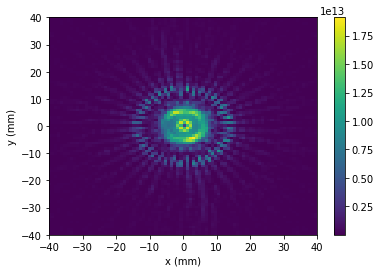

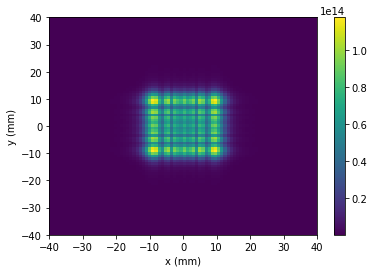

In [37]:
lam=constants.c/nu
k0=2*np.pi/lam
Nx,Ny=np.shape(Exy0)

dx=(np.max(x)-np.min(x))/(np.size(x)-1)
dy=(np.max(y)-np.min(y))/(np.size(y)-1)

u=np.linspace(-1/2/dx,(Nx/2-1)/Nx/dx,Nx,endpoint=True)
v=np.linspace(-1/2/dy,(Ny/2-1)/Ny/dy,Ny,endpoint=True)

#uu,vv=np.meshgrid(u,v)

a=f*lam*u
b=f*lam*v

aa,bb=np.meshgrid(a,b)

Pab=-1j/(f*lam)*np.exp(1j*k0/(2*d_detect)*((1-d/d_detect))*(aa**2+bb**2))

Exy0_fraun=np.exp(1j*k0/(2*d_detect)*((1-d/d_detect))*(xx**2+yy**2))

Eab_wo_shift = np.fft.fft2( np.fft.fftshift(Exy0))
Eab = np.fft.ifftshift( np.fft.fft2(  np.fft.fftshift( Exy0*Exy0_fraun  ) ) )
Eab_wo_fraun = np.fft.ifftshift( np.fft.fft2(  np.fft.fftshift( Exy0  ) ) )


# plotting the Intensity
fig = plt.figure()
plt.pcolor(a*1000,b*1000,np.abs(Pab*Eab)**2)
plt.ylim(-40,40)
plt.xlim(-40,40)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()


# BDW_all=-np.exp(1j*k0*(lens_radius**4)/(2*d_detect))

# # plotting the Intensity
# fig = plt.figure()
# plt.pcolor(a*1000,b*1000,np.abs(Pab*BDW_all*Eab)**2)
# plt.ylim(-40,40)
# plt.xlim(-40,40)
# plt.xlabel("x (mm)")
# plt.ylabel("y (mm)")
# plt.colorbar()

#  Exy0_fraun diente als vergleich um own_fft mit der fft zu vergleichen 
Exy0_fraun=np.exp(1j*k0/(2*d_detect)*((1-d/d_detect))*(xx**2+yy**2))
Eab_fraun=np.fft.ifftshift( np.fft.fft2(  np.fft.fftshift( Exy0_fraun  ) ) )
Eab_fraun_wo = np.fft.fft2(Exy0_fraun)

# plotting the Intensity
fig = plt.figure()
plt.pcolor(a*1000,b*1000,np.abs(Pab*Eab_fraun)**2)
plt.ylim(-40,40)
plt.xlim(-40,40)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()


## Implementing angular spectra of circ aperture

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[[4.24016400e-05 4.20716813e-05 4.17443721e-05 ... 4.14197753e-05
  4.17443721e-05 4.20716813e-05]
 [4.20716813e-05 4.17391143e-05 4.14091766e-05 ... 4.10819313e-05
  4.14091766e-05 4.17391143e-05]
 [4.17443721e-05 4.14091766e-05 4.10765887e-05 ... 4.07466725e-05
  4.10765887e-05 4.14091766e-05]
 ...
 [4.14197753e-05 4.10819313e-05 4.07466725e-05 ... 4.04140631e-05
  4.07466725e-05 4.10819313e-05]
 [4.17443721e-05 4.14091766e-05 4.10765887e-05 ... 4.07466725e-05
  4.10765887e-05 4.14091766e-05]
 [4.20716813e-05 4.17391143e-05 4.14091766e-05 ... 4.10819313e-05
  4.14091766e-05 4.17391143e-05]]
[[ 0.01177665-1.92582855e-02j  0.00502309-3.03499683e-03j
   0.0056756 +7.39937090e-03j ...  0.00317641-9.55232652e-03j
  -0.00326252+7.58380645e-03j  0.00440366-1.94541737e-03j]
 [ 0.00423154-7.97172094e-03j  0.0037763 -9.82979019e-03j
   0.00290172-6.79207517e-03j ...  0.01524752-1.23002332e-02j
   0.00914602-3.08924570e-03j  0.00760009+9.35179208e-04j]
 [-0.00153343+4.67162582e-04j -0.00912234-

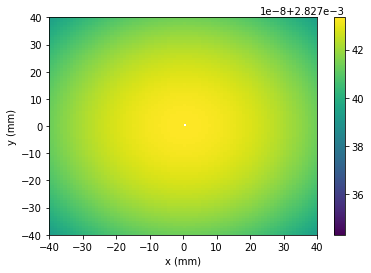

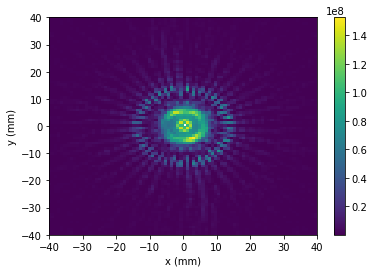

In [49]:
bessel = scipy.special.jv(1,2*np.pi*lens_radius*np.sqrt(aa**2+bb**2))
ang_spec = lens_radius*(bessel/np.sqrt(aa**2+bb**2))*np.exp(1j*2*np.pi*np.sqrt(1-(lam*aa)**2-(lam*bb)**2)*d/lam)


# circular area
circ_spec = np.sqrt((lam*aa)**2 + (lam*bb)**2)
circ = np.zeros((N,N), dtype = complex)
mask = (lam*a[np.newaxis,:])**2 + (lam*b[:,np.newaxis])**2 <= 1
circ[mask] =1

ang = ang_spec*circ


# plotting the Intensity
fig = plt.figure()
plt.pcolor(a*1000,b*1000,np.abs(ang))
plt.ylim(-40,40)
plt.xlim(-40,40)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

print(circ_spec)

Eab_ang = Eab*ang

# Eab_ang = signal.convolve2d(ang_spec,mode = "same",boundary="wrap")
print(Eab_ang)
# plotting the Intensity
fig = plt.figure()
plt.pcolor(a*1000,b*1000,np.abs(Pab*Eab_ang)**2)
plt.ylim(-40,40)
plt.xlim(-40,40)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

## Implementing Higher Order Part

## Implementing Higher Order Part

## Implementing Higher Order Part

In [27]:
higher_order_part = np.exp(1j*k0/(8*d_detect**3) * ((aa - xx)**2 + (bb - yy)**2)**2)
higher_part = np.zeros((len(x),len(y)),dtype = complex)
np.shape(higher_part)

g = np.zeros((N,N),dtype = complex)
f = np.zeros((N,N),dtype = complex)
xx_fft = np.zeros((N,N),dtype = complex)




Exy0_fraun_fft=np.exp(1j*k0/(2*d_detect)*((1-d/d_detect))*(xx**2+yy**2))
Exy0_fraun_fft_shift =np.fft.fftshift(Exy0_fraun_fft)

# w_1 = np.zeros(N,dtype=complex)
w_all = np.zeros(N,dtype=complex)
w_f_all = np.zeros(N,dtype=complex)
arr = np.zeros((N,N),dtype=complex)
# four_all = np.zeros((N,N),dtype=complex)

def w(n,k,l):
    for i in range(N):
        w_all[i] = np.exp(-2j*np.pi*((N*float(k)+i)*float(l)/n))
    return (w_all).astype(complex)

def fourier(t):
    for i in range(N):
        arr[i] = Exy0_fraun_fft_shift[:,N*t+i]
    return (arr).astype(complex)

def fourier_all(s,g,x2,w):
    four_all = 0.0
    for i in range(N):
        four_all += g[N*s+i,x2]*w[i]
        
    return (four_all).astype(complex)


for x1 in range(N):
    for x2 in range(N):
        f_even = 0.0
        f = 0.0
        for s in range(N//N):
            g_even = 0.0
            for t in range(N//N):
                
                w_all = w(N,t,x2)
                exyfr = fourier(t)
                
                g_even += np.dot(exyfr,w_all)
        
            g[:,x2] = g_even

            w_f_all = w(N,s,x1)
            f += fourier_all(s,g,x2,w_f_all)
            
        xx_fft[x1,x2] = f
        
    

In [18]:
xx_fft = np.fft.ifftshift(xx_fft)
xx_fft_all = np.dot(Eab_wo_fraun,xx_fft)

In [19]:

np.allclose(Eab, xx_fft_all)

False

In [ ]:
def fresnel_fft(N,nu,d,f,d_detect,Exy0,x,y):

    lam=constants.c/nu
    k0=2*np.pi/lam
    Nx,Ny=np.shape(Exy0)

    dx=(np.max(x)-np.min(x))/(np.size(x)-1)
    dy=(np.max(y)-np.min(y))/(np.size(y)-1)

    u=np.linspace(-1/2/dx,(Nx/2-1)/Nx/dx,Nx,endpoint=True)
    v=np.linspace(-1/2/dy,(Ny/2-1)/Ny/dy,Ny,endpoint=True)

    #uu,vv=np.meshgrid(u,v)
    a=f*lam*u
    b=f*lam*v

    aa,bb=np.meshgrid(a,b)


    xx, yy = np.meshgrid(x,y)


    xx_sh = np.fft.fftshift(xx)
    yy_sh = np.fft.fftshift(yy)
    aa_sh = np.fft.fftshift(aa)
    bb_sh = np.fft.fftshift(bb)

    #################  factor of Fresnel Approx.
    Pab=-1j/(f*lam)*np.exp(1j*k0/(2*d_detect)*((1-d/d_detect))*(aa**2+bb**2))

    ################ Frauenhofer part ###############
    Exy0_fraun=np.exp(1j*k0/(2*d_detect)*((1-d/d_detect))*(xx**2+yy**2))
    Exy0_fraun_shift = np.fft.fftshift(Exy0_fraun)

    xx_fft = np.zeros((N,N),dtype = complex)



    g_column = np.zeros((len(x),len(y)),dtype = complex)
    f_row = np.zeros((len(x),len(y)),dtype = complex)

    w_all = np.zeros(N,dtype=complex)
    w_f_all = np.zeros(N,dtype=complex)
    arr = np.zeros((N,N),dtype=complex)


    # def higher_order_shift(t,x1,x2):
    #     for i in range(N):
    #         arr[i] = np.exp(1j*k0/(8*d_detect**3) * ((aa_sh[:,x2]-xx_sh[:,N*t+i])**2+(bb_sh[:,x2]-yy_sh[:,N*t+1])**2)**2)
    #     return (arr).astype(complex)

    def w(n,k,l):
        for i in range(N):
            w_all[i] = np.exp(-2j*np.pi*((N*float(k)+i)*float(l)/n))
        return (w_all).astype(complex)

    def fourier(t):
        for i in range(N):
            g_fourier[i] = Exy0_fraun_shift[:,N*t+i]
        return (g_fourier).astype(complex)'

    def fourier_all(s,g,x2,w):
        fourier_f = 0.0
        for i in range(N):
            fourier_f += g[N*s+i,x2]*w[i]
        return (fourier_f).astype(complex)

    for x1 in range(N):
        for x2 in range(N):
            f_row = 0.0
            for s in range(N//N):
                g_value = 0.0
                for t in range(N//N):

                    w_all = w(N,t,x2)
                    Exy0frauenhofer = fourier(t)

                    g_value += np.dot(Exy0frauenhofer,w_all)

                g_column[:,x2] = g_value

                w_f_all = w(N,s,x1)
                f_row += fourier_all(s,g_column,x2,w_f_all)

            xx_fft[x1,x2] = f_row

        print(x1)

    ################## Fourier Transform of the Fresnel-Approx.######################
    # Intensity in the integral needs a factor:
    Exy0=Exy0*np.exp(1j*k0/(2*d_detect)*((1-d/d_detect))*(xx**2+yy**2))

    # FFT of Exy0:
    Eab= np.fft.ifftshift( np.fft.fft2(  np.fft.fftshift( Exy0  ) ) )

    #################################################################################

    ########### Convolve Eab and higher_order_fft ##############################
    higher_order_fft = np.fft.ifftshift(higher_order_fft)
    Eab = signal.convolve(Eab,higher_order_fft,mode = "same", method = "auto")

    return a,b,Eab

# implement higher order in code above

In [17]:
higher_order_part = np.exp(1j*k0/(8*d_detect**3) * ((aa - xx)**2 + (bb - yy)**2)**2)
higher_part = np.zeros((len(x),len(y)),dtype = complex)
np.shape(higher_part)

g = np.zeros((N,N),dtype = complex)
f = np.zeros((N,N),dtype = complex)
xx_fft2 = np.zeros((N,N),dtype = complex)

Exy0_fraun=np.exp(1j*k0/(2*d_detect)*((1-d/d_detect))*(xx**2+yy**2))
Exy0_fraun_shift = np.fft.fftshift(Exy0_fraun)

# w_1 = np.zeros(N,dtype=complex)
w_all = np.zeros(N,dtype=complex)
w_f_all = np.zeros(N,dtype=complex)
arr = np.zeros((N,N),dtype=complex)
# four_all = np.zeros((N,N),dtype=complex)

def w(n,k,l):
    for i in range(N):
        w_all[i] = np.exp(-2j*np.pi*((N*float(k)+i)*float(l)/n))
    return (w_all).astype(complex)

def fourier(t):
    for i in range(N):
        arr[i] = Exy0_fraun_shift[:,N*t+i]
    return (arr).astype(complex)

def fourier_all(s,g,x2,w):
    four_all = 0.0
    for i in range(N):
        four_all += g[N*s+i,x2]*w[i]
        
    return (four_all).astype(complex)


xx_sh = np.fft.fftshift(xx)
yy_sh = np.fft.fftshift(yy)
aa_sh = np.fft.fftshift(aa)
bb_sh = np.fft.fftshift(bb)

def higher_order_shift(t,x1,x2):
    for i in range(N):
        arr[i] = np.exp(1j*k0/(8*d_detect**3) * ((aa_sh[x1,x2]-xx_sh[:,N*t+i])**2+(bb_sh[x1,x2]-yy_sh[:,N*t+1])**2)**2)
    return (arr).astype(complex)

for x1 in range(N):
    for x2 in range(N):
        f_even = 0.0
        f = 0.0
        for s in range(N//N):
            g_even = 0.0
            for t in range(N//N):
                
                w_all = w(N,t,x2)
                higher_order = higher_order_shift(t,x1,x2)
                
                g_even += np.dot(higher_order,w_all)
        
            g[:,x2] = g_even

            w_f_all = w(N,s,x1)
            f += fourier_all(s,g,x2,w_f_all)
            
        xx_fft2[x1,x2] = f
        
    print(x1)
    
print(w_f_all[1])
print(np.exp(-2j*np.pi*((8*0+1)*7/8)))
print(f_even)
print(f)
print(np.shape(g))

0
1
2
3
4
5
6
7


KeyboardInterrupt: 

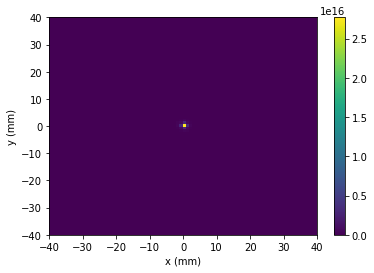

In [15]:
Eab_higher = np.fft.ifftshift(xx_fft2)

fig = plt.figure()
plt.pcolor(a*1000,b*1000,np.abs(Pab*Eab_higher)**2)
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

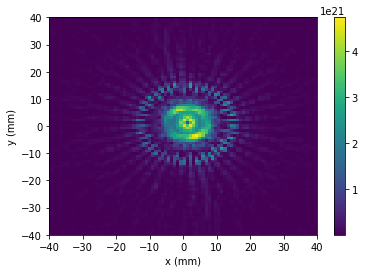

In [16]:
conv_new = signal.convolve(Eab,Eab_higher,mode = "same",method = 'auto')

fig = plt.figure()
plt.pcolor(a*1000,b*1000,np.abs(Pab*conv_new)**2)
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

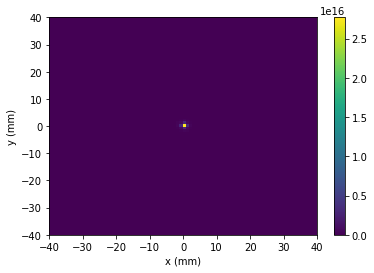

In [28]:
Eab_higher = np.fft.ifftshift(xx_fft2)

fig = plt.figure()
plt.pcolor(a*1000,b*1000,np.abs(Pab*Eab_higher)**2)
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

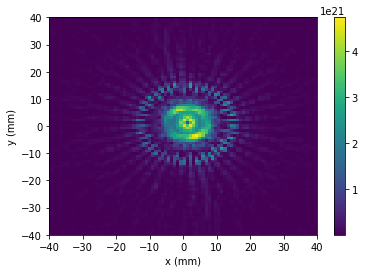

In [29]:
conv_new = signal.convolve(Eab,Eab_higher,mode = "same",method = 'auto')

fig = plt.figure()
plt.pcolor(a*1000,b*1000,np.abs(Pab*conv_new)**2)
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

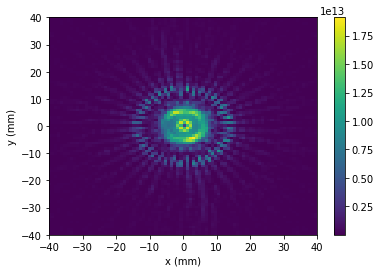

In [26]:
fig = plt.figure()
plt.pcolor(a*1000,b*1000,np.abs(Pab*Eab)**2)
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()